In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.backend import clear_session
import gc

In [25]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [26]:
mask = data["support"] == "Fixed_Free"
data = data.drop(data[mask].index)

In [27]:
to_drop=[
        "outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "y_deformation_position", "z_deformation_position",
        "support_right", "support_left"
        ]
to_keep=[
        "pipe_dn","pipe_schedule","flange_class",
        "length1", "length2", "lumped_mass",
        "frequency","x_deformation_position","allowable_deformation","support"
        ]

data.drop(columns=to_drop,inplace=True)

In [28]:
numeric_features = [
    "pipe_dn",
    'length1', 'length2', 'lumped_mass',
    ]
categorical_features = ['support',"pipe_schedule","flange_class"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [29]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [30]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [32]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [33]:
scaler_y_frequency = StandardScaler()
scaler_y_allowed_deformation = StandardScaler()
scaler_y_x_position = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowed_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowed_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_displacement = scaler_y_x_position.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y_x_position.transform(pd.DataFrame(y_test["x_deformation_position"]))



In [34]:
logdir = "logs/x_position_class/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [35]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(1024, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(256, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [36]:
model = Model(inputs=input_layer, outputs=output_layer)

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,041 (1.06 MB)

 Trainable params: 279,041 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [39]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_x_displacement,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - R2Score: 0.8878 - loss: 0.1047 - val_R2Score: 0.9845 - val_loss: 0.0152
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - R2Score: 0.9788 - loss: 0.0213 - val_R2Score: 0.9864 - val_loss: 0.0133
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - R2Score: 0.9785 - loss: 0.0212 - val_R2Score: 0.9867 - val_loss: 0.0130
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9855 - loss: 0.0145 - val_R2Score: 0.9852 - val_loss: 0.0145
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - R2Score: 0.9834 - loss: 0.0168 - val_R2Score: 0.9879 - val_loss: 0.0118
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9802 - loss: 0.0192 - val_R2Score: 0.9883 - val_loss: 0.0114
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9847 - loss: 0.0149 - val_R2Score: 0.9870 - val_loss: 0.0127
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - R2Score: 0.9842 - loss: 0.0154 - val_R2Score: 0.9881 

In [40]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_x_displacement)
print('Test accuracy:', test_mse)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2Score: 0.9240 - loss: 0.0771
Test accuracy: 0.9656122922897339


In [41]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,125 (3.19 MB)

 Trainable params: 279,041 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 558,084 (2.13 MB)

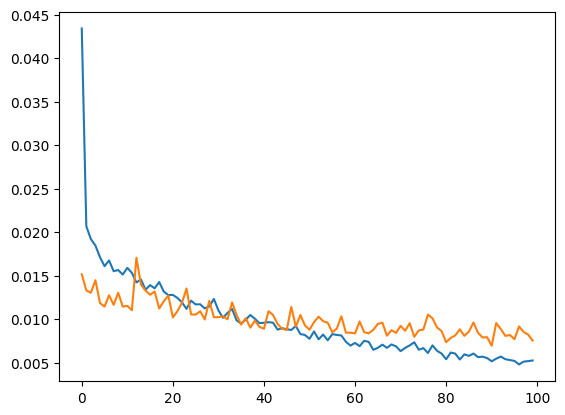

In [42]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [43]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_x_position.inverse_transform((predictions_scaled))

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [44]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
             0
0  -999.531677
1   494.323669
2  2250.979492
3  -200.829224
4  -677.661133


In [45]:
true= y_test["x_deformation_position"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

27792.250048907776

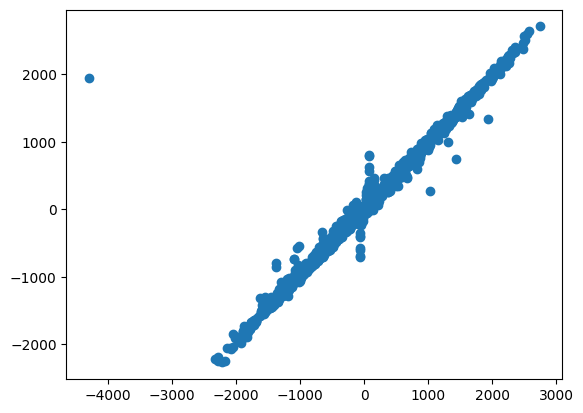

In [46]:
pred=predictions_df
ansys=y_test["x_deformation_position"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 150],[0, 150])
plt.show()

In [47]:
clear_session()
del model
gc.collect()

0